In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 17.2 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pickle

In [ ]:
def vec_check(vec,electron_num):
    """
    To check solution conserve the charge
    """
    for i,e in enumerate(vec):
        if np.abs(e) > 1e-8:
            e_occ=bin(i)[2:]
            lst=' '.join(e_occ).split(' ')
            cv=tuple(map(int, lst))
            e_num=sum(cv)
            if e_num!=electron_num:
                return False
    return True

def exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge):
    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]
    H_matrix=qml.matrix(Ha)
    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    vals, vecs = np.linalg.eigh(H_matrix+0.0001*SZ)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]

    print('The ground state energy with sz=0:',eng[0])
    E_collect=[eng[0]]

    elec_num=num_electrons

    for i in range(1,len(eng)): # Finding first excited state with -1 Sz
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if  np.abs(Sz)<1e-5 and vec_check(vec[:,i],elec_num):
            print('The excited energy:',(eng[i]-0.0001*Sz).real, ' with Sz=', np.round(Sz.real,3))
            E_collect.append(eng[i])


    return E_collect

We use exact diagonalization to get the corresponding ground state and first excited state.

In [ ]:
r_lst=[0.8,1.2,1.6,2.0,2.4]
E_dict={}
for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H","H","H","H"]
    geometry=np.array([0.0, 0.0, 0.0, L, 0.0, 0.0, 2*L, 0, 0, 3*L,0,0])

    charge=0
    num_electrons=4
    E_c=exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge)
    for i,e in enumerate(E_c):
        if i not in E_dict:
            E_dict[i]=[e]
        else:
            E_dict[i].append(e)

The ground state energy with sz=0: -2.1675605463844354
The excited energy: -1.807912190544876  with Sz= -0.0
The excited energy: -1.5145835733726418  with Sz= 0.0
The excited energy: -1.499120102282562  with Sz= 0.0
The excited energy: -1.4087404637822842  with Sz= 0.0
The excited energy: -1.085586970544463  with Sz= -0.0
The excited energy: -1.0627965252587999  with Sz= 0.0
The excited energy: -0.9104526642905713  with Sz= 0.0
The excited energy: -0.7793736739334944  with Sz= -0.0
The excited energy: -0.7555976474282615  with Sz= 0.0
The excited energy: -0.6714773911126263  with Sz= 0.0
The excited energy: -0.6080252657463797  with Sz= -0.0
The excited energy: -0.5256520892433928  with Sz= -0.0
The excited energy: -0.5110415214454779  with Sz= 0.0
The excited energy: -0.41860876084122917  with Sz= -0.0
The excited energy: -0.18356883748529831  with Sz= -0.0
The excited energy: -0.16021019549158547  with Sz= 0.0
The excited energy: -0.11036695742415949  with Sz= -0.0
The excited energy

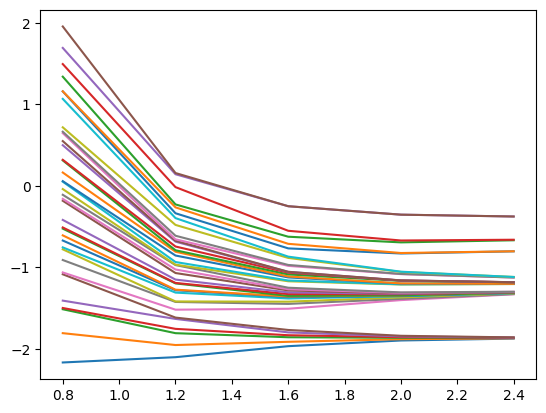

In [ ]:
for i in E_dict.keys():
    if len(r_lst)==len(E_dict[i]):
        plt.plot(r_lst,E_dict[i])


# Subspace Search Variational Quantum Eigensolver

The the Subspace Search Variational Quantum Eigensolver (SSVQE) can obtain ground state and excied state at the same time. Its cost function is designed as

$C(\vec{\theta})=\sum_{i}w_{i}\left\langle \psi_{i}(\vec{\theta})\left|H\right|\psi_{i}(\vec{\theta_{i}})\right\rangle $

where $w_{i}\in[0,1]$. Usually, the lower states have larger weight and the weight of ground is set to 1. Besides, the initial trial state $\left|\psi_{i}\right\rangle$ should be orthogonal with each other.  

As the plot shown below, each qubit can be explained as whether the electrons occupy the spin orbitals. $1$ means the occupied orbital, while $0$ means empty orbital. Even (odd) sites mean spin up (down) orbital.(Plot from	Phys. Chem. Chem. Phys., 2021,23, 26438-26450)

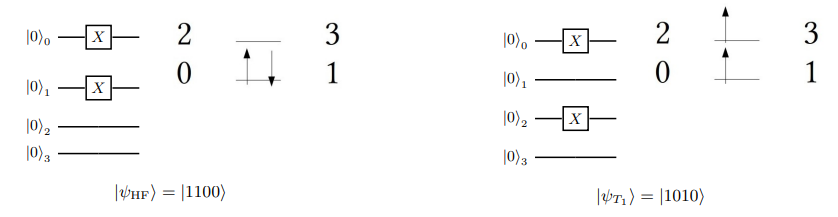

In [ ]:
def bit_to_vec(bitstring_dict,num_qubits):
    vec=np.zeros(2**num_qubits)
    amp=0
    for i in range(2**num_qubits):
        bitstr=bin(i)[2:]
        if len(bitstr) < num_qubits:
            bitstr=(num_qubits-len(bitstr))*'0'+bitstr

        if bitstr in bitstring_dict:
            vec[i]=bitstring_dict[bitstr]
            amp+=np.abs(bitstring_dict[bitstr])**2
    vec=vec/np.sqrt(amp)
    return vec

In [ ]:
class FS_SS_vqe_ch():
    def __init__(self,state_lst,num_electrons,symbol,geometry,charge) -> None:
        """
        state_lst list(dict): The list of trial states for training the VQD

        For instance, you want to create |ψ_1>=1/√2|110000>+1/√2|001100>
        and |ψ_2>=1/√2|110000>-1/√2|001100> as the 6 qubits trial states

        state_psi_1={'110000':1,'001100':1}
        state_psi_2={'110000':1,'001100':-1}
        state_lst=[state_psi_1,state_psi_2]

        The length of bitstring is determined by the number of orbital. H3+ has 6 orbitals so the
        of bit string is 6.

        num_electrons (int): The number of electrons

        symbol list(str): The chemistry symbol (i.e. ["H","H"] for H2)

        geometry numpy array: The coodinates of the atoms in bohr

        charge int: the charge of the chemical molecules
        """
        self.num_electrons=num_electrons
        self.symbol=symbol
        self.geometry=geometry
        self.charge=charge

        self.hamiltonian=self.Ch_hamiltonian(symbol,geometry,num_electrons,charge)
        self.num_qubits = len(self.hamiltonian.wires)
        self.sz=qml.qchem.spinz(self.num_qubits)
        self.singles, self.doubles = qml.qchem.excitations(self.num_electrons, self.num_qubits)

        self.state_lst=[]
        for stat in state_lst:
            self.state_lst.append(bit_to_vec(stat,self.num_qubits))
        H_matrix=qml.matrix(self.hamiltonian)
        H_sq=H_matrix.dot(H_matrix)
        self.H_sq_ob=qml.Hermitian(H_sq, wires=range(self.num_qubits))

        self.dev = qml.device("default.qubit", wires=self.num_qubits)
        self.cost_h_fn = qml.QNode(self.circuit, self.dev)
        self.Sz_fn = qml.QNode(self.circuit_sz, self.dev)
        self.cost_hsq_fn = qml.QNode(self.circuit_h_sq, self.dev)

    def Ch_hamiltonian(self,symbol,geometry,num_electrons,charge):
        return qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]

    def hf(self,electrons, num_qubits):
        return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

    def circuit(self,state,weights):
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.hamiltonian)


    def circuit_sz(self,state,weights):
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.sz)

    def circuit_h_sq(self,state,weights):
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.H_sq_ob)

    def cost_fn(self,params):
        cost=0
        for ind, stat in enumerate(self.state_lst):
            sq_h=np.sqrt(self.cost_hsq_fn(stat,params)-2*self.om*self.cost_h_fn(stat,params)+self.om**2)
            #print(self.cost_hsq_fn(stat,params))
            #print(self.cost_h_fn(stat,params))
            #print(sq_h)
            cost+=self.w[ind]*sq_h
        return cost

    def fluctuation(self,stat,params):
        return self.cost_hsq_fn(stat,params)-self.cost_h_fn(stat,params)**2

    def run(self,om=0.0,w=None,epochs=400,stepsize=0.5,num_layer=2,cov=1e-5,print_train=True):
        """
        w: the weight of each orthogonal state's cost function value.

        epochs: the iteration of training

        stepsize: the learning rate

        num_layer: the number of layer ansatz

        cov: if the difference between previous cost and current is samller than cov, the training will be stopped

        print_train: Whether you want to print the training process
        """
        self.om=om
        if w==None:
            self.w=[1.0]+(len(self.state_lst)-1)*[0.5]
        else:
            self.w=w

        self.num_layer=num_layer
        opt = qml.AdamOptimizer(stepsize=stepsize)
        self.weights =np.zeros(num_layer*len(self.doubles + self.singles), requires_grad=True)

        i=0
        iter=[]
        cost_val=[]
        Lowest_cost=0
        self.best_weights=self.weights

        cov=cov
        E_pev=[0.0]*len(self.state_lst)
        E_lst=[0.0]*len(self.state_lst)
        E_sq_lst=[0.0]*len(self.state_lst)
        E_pev=np.array(E_pev)
        E_lst=np.array(E_lst)
        self.fl=[]
        for _ in range(epochs):
            self.weights = opt.step(self.cost_fn, self.weights)
            iter.append(i)
            cost=self.cost_fn(self.weights)
            for j,stat in enumerate(self.state_lst):
                E_lst[j]=self.cost_h_fn(stat,self.weights)
                E_sq_lst[j]=self.cost_hsq_fn(stat,self.weights)

            #print(self.cost_fn(self.weights))
            if Lowest_cost>cost:
                Lowest_cost=cost
                self.best_weights=self.weights
            cost_val.append(E_lst)

            i=i+1
            if print_train:
                print('iter:',i)
                for j,stat in enumerate(self.state_lst):
                    print(' E0:',E_lst[j],' Sz:',self.Sz_fn(stat,self.weights))
                    print(' E0_fl:',np.sqrt(E_sq_lst[j]-2*self.om*E_lst[j]+self.om**2))
            E_diff=np.abs(E_lst-E_pev)
            if np.all(E_diff<cov):
                break

            #for k in range(len(self.state_lst)):
            E_pev=E_lst.copy()
        print('fluctuation:')
        for j,stat in enumerate(self.state_lst):
            fl=self.fluctuation(stat,self.weights)
            self.fl.append(fl)
            print(fl)
        self.iter_lst=iter
        self.E_lst=E_lst
        return E_lst

In [ ]:
r_lst=[0.8,1.2,1.6,2.0,2.4]
E1_lst=[]
E2_lst=[]
E3_lst=[]

F1_lst=[]
F2_lst=[]
F3_lst=[]
iter_lst=[]
for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H","H","H","H"]
    geometry=np.array([0.0, 0.0, 0.0, L, 0.0, 0.0, 2*L, 0, 0, 3*L,0,0])

    charge=0
    num_electrons=4
    e_stat_1={'11011000': 1}
    e_stat_2={'01111000': 1}
    e_stat_3={'11001100': 1}
    stat_lst=[e_stat_1,e_stat_2,e_stat_3]
    FS_SS_vqe=FS_SS_vqe_ch(stat_lst,num_electrons,symbol,geometry,charge)
    w=[1.0,0.5,0.3]
    E1,E2,E3=FS_SS_vqe.run(om=-1.0,w=w,epochs=400,stepsize=0.2,num_layer=5)
    iter=FS_SS_vqe.iter_lst[-1]
    iter_lst.append(iter)
    E_lst=[E1,E2,E3]
    inds=np.argsort(E_lst)
    E1,E2,E3=np.array(E_lst)[inds]

    E1_lst.append(E1)
    E2_lst.append(E2)
    E3_lst.append(E3)

    F1,F2,F3=np.array(FS_SS_vqe.fl)[inds]

    F1_lst.append(F1)
    F2_lst.append(F2)
    F3_lst.append(F3)

Streaming output truncated to the last 5000 lines.
 E0_fl: 0.08821340674197642
iter: 88
 E0: -1.0547328372760971  Sz: 2.7755575615628914e-17
 E0_fl: 0.05687273850407382
 E0: -1.057121941128002  Sz: 6.938893903907228e-17
 E0_fl: 0.05925552657107471
 E0: -1.0841204783651917  Sz: -2.7755575615628914e-17
 E0_fl: 0.08769232870884994
iter: 89
 E0: -1.0546025056712474  Sz: -2.7755575615628914e-17
 E0_fl: 0.05611139726700833
 E0: -1.0574375077166926  Sz: -5.551115123125783e-17
 E0_fl: 0.06096199718028807
 E0: -1.0840805971641805  Sz: -2.7755575615628914e-17
 E0_fl: 0.0871209342000953
iter: 90
 E0: -1.0544266629701808  Sz: -2.7755575615628914e-17
 E0_fl: 0.05505295993750364
 E0: -1.0578447741360117  Sz: 2.7755575615628914e-17
 E0_fl: 0.06377471038650255
 E0: -1.0839459791335873  Sz: -1.3877787807814457e-17
 E0_fl: 0.0876023764179246
iter: 91
 E0: -1.0545129143271406  Sz: 0.0
 E0_fl: 0.05516907924375102
 E0: -1.0582503435787  Sz: -2.7755575615628914e-17
 E0_fl: 0.0662672788167266
 E0: -1.0834063

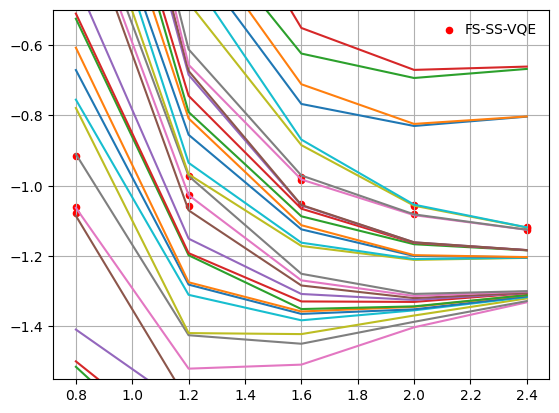

In [ ]:
for i in E_dict.keys():
    if len(r_lst)==len(E_dict[i]) :
        plt.plot(r_lst,E_dict[i])

plt.scatter(r_lst,E1_lst,s=20,c='r',label='FS-SS-VQE')
plt.scatter(r_lst,E2_lst,s=20,c='r')
plt.scatter(r_lst,E3_lst,s=20,c='r')

plt.legend(frameon=False,labelspacing = 0.09,handlelength=0.7)
plt.ylim(-1.55,-0.5)
#plt.legend()
plt.grid()

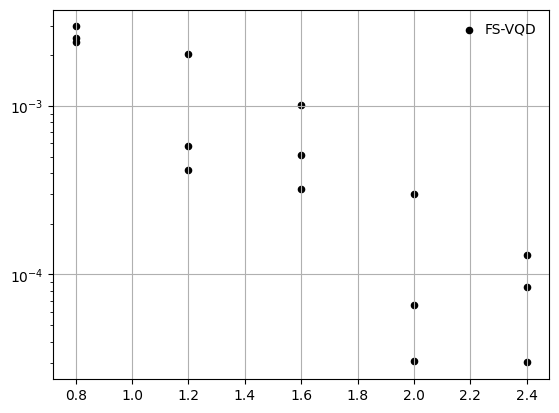

In [ ]:
plt.scatter(r_lst,F1_lst,s=20,c='k',label='FS-VQD')
plt.scatter(r_lst,F2_lst,s=20,c='k')
plt.scatter(r_lst,F3_lst,s=20,c='k')
plt.yscale('log')
plt.legend(frameon=False,labelspacing = 0.09,handlelength=0.7)
#plt.legend()
plt.grid()

In [ ]:
with open('H4_E.pickle', 'wb') as handle:
    pickle.dump(E_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('FS_SS_VQE_0.npy', 'wb') as f:
    np.save(f, np.array(E1_lst))

with open('FS_SS_VQE_1.npy', 'wb') as f:
    np.save(f, np.array(E2_lst))

with open('FS_SS_VQE_2.npy', 'wb') as f:
    np.save(f, np.array(E3_lst))

In [ ]:
with open('FS_SS_VQE_0_F.npy', 'wb') as f:
    np.save(f, np.array(F1_lst))

with open('FS_SS_VQE_1_F.npy', 'wb') as f:
    np.save(f, np.array(F2_lst))

with open('FS_SS_VQE_2_F.npy', 'wb') as f:
    np.save(f, np.array(F3_lst))

In [ ]:
with open('FS_SS_VQE_iter.npy', 'wb') as f:
    np.save(f, np.array(iter_lst))